In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
# Create dictionary of proteins and their corresponding protein families.
protein_families_dict = {"SLC": ['SLC44A4', 'SLC33A1', 'SLC26A4', 'SLC52A3', 'SLC22A4', 'SLC26A5', 'SLC17A8', 'SLC19A2', 'SLC52A2', 'SLC4A11'], "SIX": ['SIX2', 'SIX1', 'SIX5'], 'PEX': ['PEX1', 'PEX6', 'PEX26'], 'PAX': ['PAX1', 'PAX3'], 'POLR1': ['POLR1D', 'POLR1B', 'POLR1C'], 'POU': ['POU3F4', 'POU4F3'], 'GRXCR1': ['GRXCR1', 'GRXCR2'], "HOX": ['HOXB1', 'HOXA2'], 'ATP': ['ATP6V1B1', 'ATP2B2', 'ATP6V1B2', 'ATP6V0A4'], 'EYA': ['EYA1', 'EYA4'], 'DIAPH': ['DIAPH1', 'DIAPH3'], 'CLDN': ['CLDN14', 'CLDN9'], 'KCN': ['KCNE1', 'KCNJ10', 'KCNQ1', 'KCNQ4'], 'FGFR': ['FGFR1', 'FGFR3', 'FGFR2'], 'GJB': ['GJB2', 'GJB3'], 'MYO': ['MYO6', 'MYO7A', 'MYO3A'], 'MAN': ['MAN2B1', 'MANBA'], 'OTO': ['OTOF', 'OTOA'], 'USH': ['USH1G', 'USH1C']}

In [4]:
# print the keys of the dictionary
print(protein_families_dict.keys())

dict_keys(['SLC', 'SIX', 'PEX', 'PAX', 'POLR1', 'POU', 'GRXCR1', 'HOX', 'ATP', 'EYA', 'DIAPH', 'CLDN', 'KCN', 'FGFR', 'GJB', 'MYO', 'MAN', 'OTO', 'USH'])


Protein family: SLC. Number of variants: 394. Number of genes: 10
Protein family: SIX. Number of variants: 32. Number of genes: 3
Protein family: PEX. Number of variants: 107. Number of genes: 3
Protein family: PAX. Number of variants: 70. Number of genes: 2
Protein family: POLR1. Number of variants: 42. Number of genes: 3
Protein family: POU. Number of variants: 41. Number of genes: 2
Protein family: GRXCR1. Number of variants: 11. Number of genes: 2
Protein family: HOX. Number of variants: 7. Number of genes: 2
Protein family: ATP. Number of variants: 64. Number of genes: 4
Protein family: EYA. Number of variants: 54. Number of genes: 2
Protein family: DIAPH. Number of variants: 26. Number of genes: 2
Protein family: CLDN. Number of variants: 11. Number of genes: 2
Protein family: KCN. Number of variants: 453. Number of genes: 4
Protein family: FGFR. Number of variants: 286. Number of genes: 3
Protein family: GJB. Number of variants: 242. Number of genes: 2
Protein family: MYO. Numbe

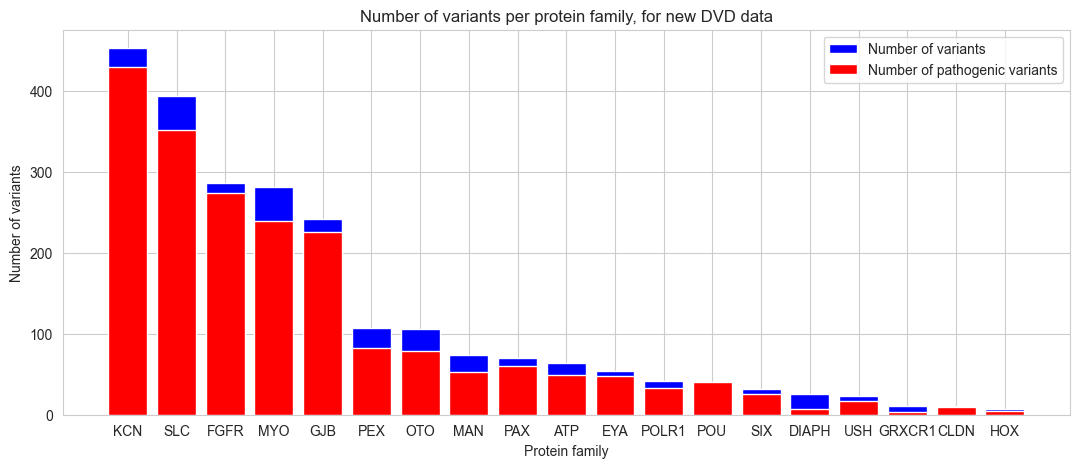

In [13]:

# Print how many variant there are in each protein family, based on the data.
filename = 'C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\Data\\data_for_all_dvd.csv'
data = pd.read_csv(f"{filename}", index_col=False)
number_of_variants_per_family = {}
number_of_pathogenic_variants_per_family = {}
for key in protein_families_dict.keys():
    print(f"Protein family: {key}. Number of variants: {len(data[data['gene'].isin(protein_families_dict[key])])}. Number of genes: {len(protein_families_dict[key])}")
    number_of_variants_per_family[key] = len(data[data['gene'].isin(protein_families_dict[key])])
    # Find the number of pathogenic variants in each protein family.
    number_of_pathogenic_variants_per_family[key] = len(data[(data['gene'].isin(protein_families_dict[key])) & (data['pathogenicity'] == 'pathogenic')])
    

# Plot the number of variants per protein family, ordered by the number of variants.
number_of_variants_per_family = dict(sorted(number_of_variants_per_family.items(), key=lambda item: item[1], reverse=True))
number_of_pathogenic_variants_per_family = dict(sorted(number_of_pathogenic_variants_per_family.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(13, 5))
plt.bar(number_of_variants_per_family.keys(), number_of_variants_per_family.values(), color='blue', label='Number of variants')
plt.bar(number_of_pathogenic_variants_per_family.keys(), number_of_pathogenic_variants_per_family.values(), color='red', label='Number of pathogenic variants')
plt.xlabel("Protein family")
plt.ylabel("Number of variants")
plt.title("Number of variants per protein family, for new DVD data")
plt.legend()
plt.show()



    


In [186]:
"""MUST CHANGE THESE VARIABLES BEFORE RUNNING THE SCRIPT:
protein_family: The protein family to analyze. Must be one of the keys in protein_families_dict."""

protein_family = "USH"
filename = 'C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\Data\\data_for_all_dvd.csv'
data = pd.read_csv(f"{filename}", index_col=False)
data

,gene,variant,stability_WT,stability_MUT,stability_delta,pathogenicity,Absolute value of delta,blosum,hydrophobicity_WT,hydrophobicity_MUT,...,sasa_delta,secondary_structure,sequence_length,protein_contain_transmembrane,is_residue_transmembranal,aa_WT,aa_MUT,RSA_WT,RSA_MUT,source
0,POLR1D,L111P,55.4166,59.2536,3.8370,pathogenic,3.8370,-3,3.8,-1.6,...,-26.79,Helix,133,False,False,L,P,0.445445,0.378506,dvd
1,POLR1D,T50I,52.5256,53.9242,1.3986,pathogenic,1.3986,-1,-0.7,4.5,...,37.23,Helix,133,False,False,T,I,0.653988,0.737590,dvd
2,POLR1D,L55V,53.5827,56.1836,2.6009,pathogenic,2.6009,1,3.8,4.2,...,-0.01,Helix,133,False,False,L,V,0.000052,0.000000,dvd
3,POLR1D,G99S,53.3779,55.2641,1.8862,pathogenic,1.8862,0,-0.4,-0.8,...,2.56,Helix,133,False,False,G,S,0.011237,0.025524,dvd
4,POLR1D,C68W,55.1261,90.0561,34.9300,pathogenic,34.9300,-2,2.5,-0.9,...,0.41,Beta strand,133,False,False,C,W,0.002838,0.003144,dvd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5469,PJVK,G292R,211.5760,215.0030,3.4270,benign,3.4270,-2,-0.4,-4.5,...,146.47,Loop,352,False,False,G,R,0.759278,0.830642,dvd
5470,PJVK,R265C,211.4450,211.7910,0.3460,benign,0.3460,-3,-4.5,2.5,...,-110.68,Loop,352,False,False,R,C,0.821547,0.723176,dvd
5471,PJVK,M260V,209.8750,211.5100,1.6350,benign,1.6350,1,1.9,4.2,...,-31.74,Loop,352,False,False,M,V,0.484729,0.404000,dvd
5472,PJVK,R265G,211.4450,211.7550,0.3100,benign,0.3100,-2,-4.5,-0.4,...,-154.07,Loop,352,False,False,R,G,0.821547,0.656082,dvd


In [187]:
# Remove all rows where the gene is not in the protein family "protein_family".
data = data[data["gene"].isin(protein_families_dict[protein_family])]
data

,gene,variant,stability_WT,stability_MUT,stability_delta,pathogenicity,Absolute value of delta,blosum,hydrophobicity_WT,hydrophobicity_MUT,...,sasa_delta,secondary_structure,sequence_length,protein_contain_transmembrane,is_residue_transmembranal,aa_WT,aa_MUT,RSA_WT,RSA_MUT,source
96,USH1G,S119P,450.531,453.315,2.784,pathogenic,2.784,-1,-0.8,-1.6,...,9.22,Loop,461,False,False,S,P,0.326993,0.363506,dvd
97,USH1G,D354Y,450.943,452.156,1.213,pathogenic,1.213,-3,-3.5,-1.3,...,60.61,Loop,461,False,False,D,Y,0.758235,0.793725,dvd
98,USH1G,R447W,445.767,444.628,-1.139,pathogenic,1.139,-3,-4.5,-0.9,...,-17.27,Helix,461,False,False,R,W,0.410981,0.347121,dvd
99,USH1G,M104V,438.658,439.991,1.333,pathogenic,1.333,1,1.9,4.2,...,-9.96,Loop,461,False,False,M,V,0.141970,0.114303,dvd
100,USH1G,L396Q,445.598,448.466,2.868,pathogenic,2.868,-2,3.8,-3.5,...,-0.10,Helix,461,False,False,L,Q,0.000524,0.000000,dvd
101,USH1G,L48P,447.074,457.965,10.891,pathogenic,10.891,-3,3.8,-1.6,...,4.74,Loop,461,False,False,L,P,0.000000,0.030779,dvd
102,USH1G,L399P,447.730,451.356,3.626,pathogenic,3.626,-3,3.8,-1.6,...,19.14,Turn,461,False,False,L,P,0.085550,0.230390,dvd
103,USH1G,D458V,451.131,451.038,-0.093,pathogenic,0.093,-3,-3.5,4.2,...,-5.04,Loop,461,False,False,D,V,0.766738,0.838424,dvd
104,USH1G,L84P,449.848,457.181,7.333,pathogenic,7.333,-3,3.8,-1.6,...,3.71,Loop,461,False,False,L,P,0.000942,0.025260,dvd
3599,USH1C,R89H,290.172,291.149,0.977,pathogenic,0.977,0,-4.5,-3.2,...,-61.89,Beta strand,552,False,False,R,H,0.690906,0.561111,dvd


In [188]:
# Print how many pathogenic and benign variants there are in the dataset.
print(data["pathogenicity"].value_counts())
# Print how many variants in each gene
print(data["gene"].value_counts())

pathogenicity
pathogenic    17
benign         6
Name: count, dtype: int64
gene
USH1G    12
USH1C    11
Name: count, dtype: int64


In [181]:
data = pd.get_dummies(data, columns=["secondary_structure"])

mapping = {"benign": 0, "pathogenic": 1}
data["pathogenicity"] = data["pathogenicity"].map(mapping)

data = data.drop(
    labels=["stability_delta", "sequence_length", "stability_WT", "stability_MUT", "hydrophobicity_WT", "hydrophobicity_MUT", "volume_WT",
            "volume_MUT", "oda_MUT", "oda_WT", "sasa_WT", "sasa_MUT", "RSA_MUT",
            "protein_contain_transmembrane", "is_residue_transmembranal", "aa_WT", "aa_MUT"], axis=1, inplace=False)

data

,gene,variant,pathogenicity,Absolute value of delta,blosum,hydrophobicity_delta,volume_delta,plddt_residue,opra_WT,opra_MUT,opra_delta,oda_delta,sasa_delta,RSA_WT,source,secondary_structure_Loop
1539,OTOF,E1733K,1,0.960,1,-0.4,30.2,93.63,0.10,-0.08,-0.18,4.00,20.47,0.154720,dvd,True
1540,OTOF,R922L,1,1.010,-2,8.3,-6.7,84.88,-0.28,-0.18,0.10,-3.97,-31.31,0.296000,dvd,True
1541,OTOF,G368R,1,2.060,-2,-4.1,113.3,80.12,-0.06,-0.37,-0.31,6.09,158.36,0.469278,dvd,True
1542,OTOF,A964E,1,7.350,-1,-5.3,49.8,95.31,0.00,0.00,0.00,0.00,0.00,0.000000,dvd,True
1543,OTOF,G1905V,1,9.770,-3,4.6,79.9,90.95,0.00,0.00,0.00,0.00,0.00,0.000000,dvd,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4775,OTOF,R1157Q,0,0.290,1,1.0,-29.6,95.64,-1.42,-1.14,0.28,-0.58,-8.76,0.130415,dvd,True
4776,OTOF,R33Q,0,0.240,1,1.0,-29.6,91.19,-0.34,-0.05,0.29,-4.43,-82.89,0.706113,dvd,True
4777,OTOF,R654Q,0,0.110,1,1.0,-29.6,35.59,-1.36,-1.01,0.35,-4.44,-74.06,0.785887,dvd,True
5292,OTOA,Q381E,0,0.229,2,0.0,-5.4,82.13,-0.14,0.02,0.16,-0.46,0.47,0.335234,dvd,True


In [182]:
### Removing structural features ###

# structural_features = ["oda_delta", "stability_delta", "secondary_structure_Beta strand", "secondary_structure_Helix", "secondary_structure_Loop", "sasa_delta", "RSA_WT"]
# # Drop structural features
# data = data.drop(labels=["stability_delta"], axis=1, inplace=False)

In [183]:
data = data.drop(labels = ["source"], axis=1, inplace=False)
# data = data.drop(labels = ["position"], axis=1, inplace=False)


In [184]:
def get_mcc(tp, tn, fp, fn):
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc_score = numerator / denominator if denominator != 0 else 0
    return mcc_score

# Create list of all positions.
genes = data["gene"].unique()
tps = []
fps = []
fns = []
tns = []
errors = []
mistakes = 0

counter = 0

# Initiate a dataframe that will contain the predictions for each variant.
predictions_df = pd.DataFrame(columns=["gene", "variant", "prediction", "reality"])
predictions_df

,gene,variant,prediction,reality


In [185]:
probabilities = []
predictions = []
y_tests = []


for gene in genes:
    counter += 1
    print(f"Gene: {gene} ({counter}/{len(genes)})")
    # Create train and test sets.
    train = data[data["gene"] != gene]
    test = data[data["gene"] == gene]

    X_test = test.drop(labels=["pathogenicity", "gene", "variant"], axis=1, inplace=False)
    y_test = test["pathogenicity"]

    # Oversample the train set using SMOTE.
    X_train = train.drop(labels=["pathogenicity", "gene", "variant"], axis=1, inplace=False)
    y_train = train["pathogenicity"]
    oversample = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)
    # class_distribution = y_train_resampled.value_counts()
    # print(f"Training set: (SMOTE)\n{class_distribution}")

    xgb_classifier = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)
    xgb_classifier.fit(X_train_resampled, y_train_resampled)  # Fit the model with the resampled data
    y_pred = xgb_classifier.predict(X_test)
    
    # Predict probabilities (Instead of predicting binary values)
    prob = xgb_classifier.predict_proba(X_test)[:, 1]
    y_pred = xgb_classifier.predict(X_test)

    # Store probabilities, predictions, and ground truth labels
    probabilities.extend(prob)
    predictions.extend(y_pred)
    y_tests.extend(y_test)
    
    # Add the predictions to the predictions dataframe.
    # If there's more than one variant in the test set, add the predictions for all of them.if len(test) > 1:
    # If there's more than one variant in the test set, add the predictions for all of them.
    if len(test) > 1:
        predictions_df_gene = pd.DataFrame({
            "gene": test["gene"],
            "variant": test["variant"],
            "prediction": y_pred,
            "reality": test["pathogenicity"],
            "prediction_score": prob
        })
        predictions_df = pd.concat([predictions_df, predictions_df_gene], ignore_index=True)
    else:
        # For a single variant, use the first prediction in y_pred
        if len(y_pred) > 0:
            predictions_df_single = pd.DataFrame({
                "gene": [test["gene"].values[0]],
                "variant": [test["variant"].values[0]],
                "prediction": [y_pred[0]],
                "reality": [test["pathogenicity"].values[0]],
                "prediction_score": [prob[0]]
            })
            predictions_df = pd.concat([predictions_df, predictions_df_single], ignore_index=True)

    tp = sum((y_test == 1) & (y_pred == 1))
    fp = sum((y_test == 0) & (y_pred == 1))
    fn = sum((y_test == 1) & (y_pred == 0))
    tn = sum((y_test == 0) & (y_pred == 0))

    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)

    # print(f"tps: {sum(tps)}, fps: {sum(fps)}, fns: {sum(fns)}, tns: {sum(tns)}")

    print(f"Prediction: {y_pred}. Reality: {y_test.values}")
    
    # # print error if at least one prediction is wrong
    # if not np.array_equal(y_pred, y_test.values):
    #     print(f"Classification is wrong for position {pos}!")
    #     for i in range(len(y_pred)):
    #         if y_pred[i] != y_test.values[i]:
    #             mistakes+=1
    #             print(f"Predicted: {y_pred[i]}, reality: {y_test.values[i]}")

# Calculate MCC
TP = sum(tps)
FP = sum(fps)
FN = sum(fns)
TN = sum(tns)
mcc = get_mcc(TP, TN, FP, FN)

print(f"TP: {sum(tps)}, FP: {sum(fps)}, TN: {sum(tns)}, FN: {sum(fns)}")

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Results:")
print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"MCC: {mcc}")
print(f"Accuracy: {accuracy}")

Gene: OTOF (1/2)


ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 2, n_samples = 2

In [174]:
# print predictions_df
predictions_df

,gene,variant,prediction,reality,prediction_score
0,MYO6,H246R,1,1,0.996487
1,MYO6,R205Q,1,1,0.996113
2,MYO6,L926Q,0,1,0.260326
3,MYO6,N485K,1,1,0.806006
4,MYO6,R1181H,1,1,0.978246
...,...,...,...,...,...
276,MYO3A,E1010K,0,0,0.152287
277,MYO3A,R1313S,1,0,0.970132
278,MYO3A,I348V,1,0,0.659769
279,MYO3A,V369I,1,0,0.588059


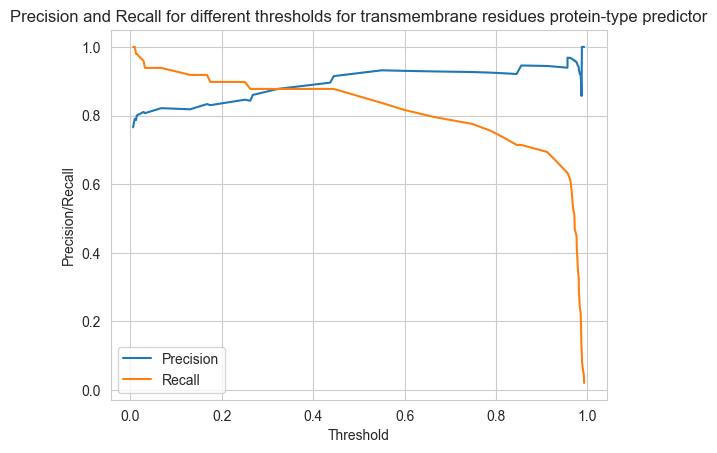

In [57]:
from sklearn.metrics import precision_recall_curve

# create a graph showing the precision for each threshold
precision, recall, thresholds = precision_recall_curve(y_tests, probabilities)
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.title("Precision and Recall for different thresholds for transmembrane residues protein-type predictor")
plt.legend()
plt.show()

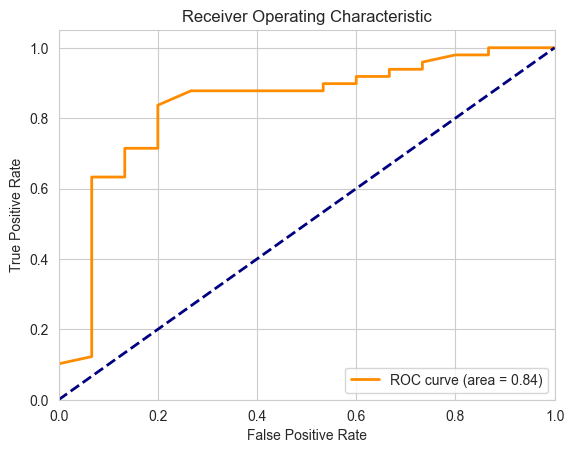

In [58]:
from sklearn.metrics import auc
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_tests, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

                   Predicted Pathogenic  Predicted Benign
Actual Pathogenic                    41                 8
Actual Benign                         3                12


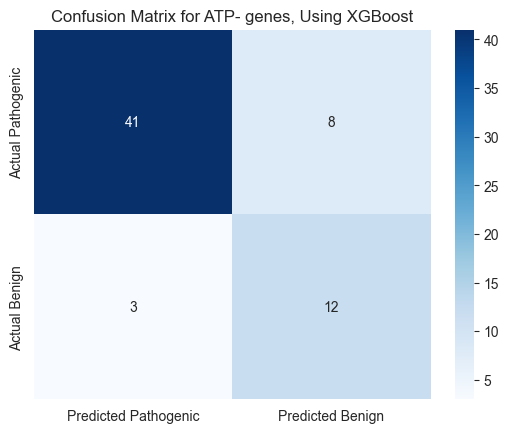

In [63]:
# Present the results in a confusion matrix, using TP, FP, FN, TN.
confusion_matrix = pd.DataFrame({"Predicted Pathogenic": [TP, FP], "Predicted Benign": [FN, TN]},
                                index=["Actual Pathogenic", "Actual Benign"])
print(confusion_matrix)

# Plot using seaborn, with light colors.
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.title(f"Confusion Matrix for {protein_family}- genes, Using XGBoost")
plt.show()


In [ ]:
data["gene"].unique()

In [ ]:
predictions_df

In [60]:
# Check how many predictions were correct.
correct_predictions = predictions_df[predictions_df["prediction"] == predictions_df["reality"]]
# Calculate the accuracy of the model.
accuracy = len(correct_predictions) / len(predictions_df)

In [61]:
accuracy

0.828125

In [64]:
# Save the predictions to a file.
predictions_df.to_csv(f"C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\predictions_vs_real\\protein_families\\predictions_vs_real_{protein_family}.csv", index=False)

In [65]:
# # Calculate per-protein accuracy, and save each protein's accuracy to a file.
# proteins = predictions_df["gene"].unique()
# accuracies = []
# for protein in proteins:
#     protein_df = predictions_df[predictions_df["gene"] == protein]
#     correct_predictions = protein_df[protein_df["prediction"] == protein_df["reality"]]
#     accuracy = len(correct_predictions) / len(protein_df)
#     accuracies.append(accuracy)
#     print(f"Accuracy for protein {protein}: {accuracy}")


In [66]:
# # Calculate per-protein metrics, and save each protein's metrics to a file.
# proteins = predictions_df["gene"].unique()
# metrics = pd.DataFrame(columns=["gene", "sensitivity", "specificity", "precision", "accuracy", "mcc", "num_variants", "num_benign", "num_pathogenic"])
# for protein in proteins:
#     protein_df = predictions_df[predictions_df["gene"] == protein]
#     TP = sum(protein_df["prediction"] & protein_df["reality"])
#     FP = sum((protein_df["reality"] == 0) & (protein_df["prediction"] == 1))
#     FN = sum((protein_df["reality"] == 1) & (protein_df["prediction"] == 0))
#     TN = sum((protein_df["reality"] == 0) & (protein_df["prediction"] == 0))
#     # to not divide by zero, check if there are any true positives, false positives, false negatives, or true negatives.
#     if TP == 0:
#         sensitivity = 0
#         precision = 0
#     else:
#         sensitivity = TP / (TP + FN)
#         precision = TP / (TP + FP)
#     if TN == 0:
#         specificity = 0
#     else:
#         specificity = TN / (TN + FP)
#     mcc = get_mcc(TP, TN, FP, FN)
#     accuracy = (TP + TN) / (TP + TN + FP + FN)
#     protein_metrics = pd.DataFrame({
#         "gene": [protein],
#         "sensitivity": [sensitivity],
#         "specificity": [specificity],
#         "precision": [precision],
#         "accuracy": [accuracy],
#         "mcc": [mcc]
#     })
#     protein_metrics["num_variants"] = len(protein_df)
#     protein_metrics["num_benign"] = sum(protein_df["reality"] == 0)
#     protein_metrics["num_pathogenic"] = sum(protein_df["reality"] == 1)
#     # add TP, FP, FN, TN to the dataframe
#     protein_metrics["TP"] = TP
#     protein_metrics["FP"] = FP
#     protein_metrics["FN"] = FN
#     protein_metrics["TN"] = TN
#     metrics = pd.concat([metrics, protein_metrics], ignore_index=True)
#     # add the number of variants for each protein
#     
# metrics.to_csv(f"C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\predictions_vs_real\\{protein_type}_{residues_or_proteins}\\metrics_{protein_type}_{residues_or_proteins}.csv", index=False)

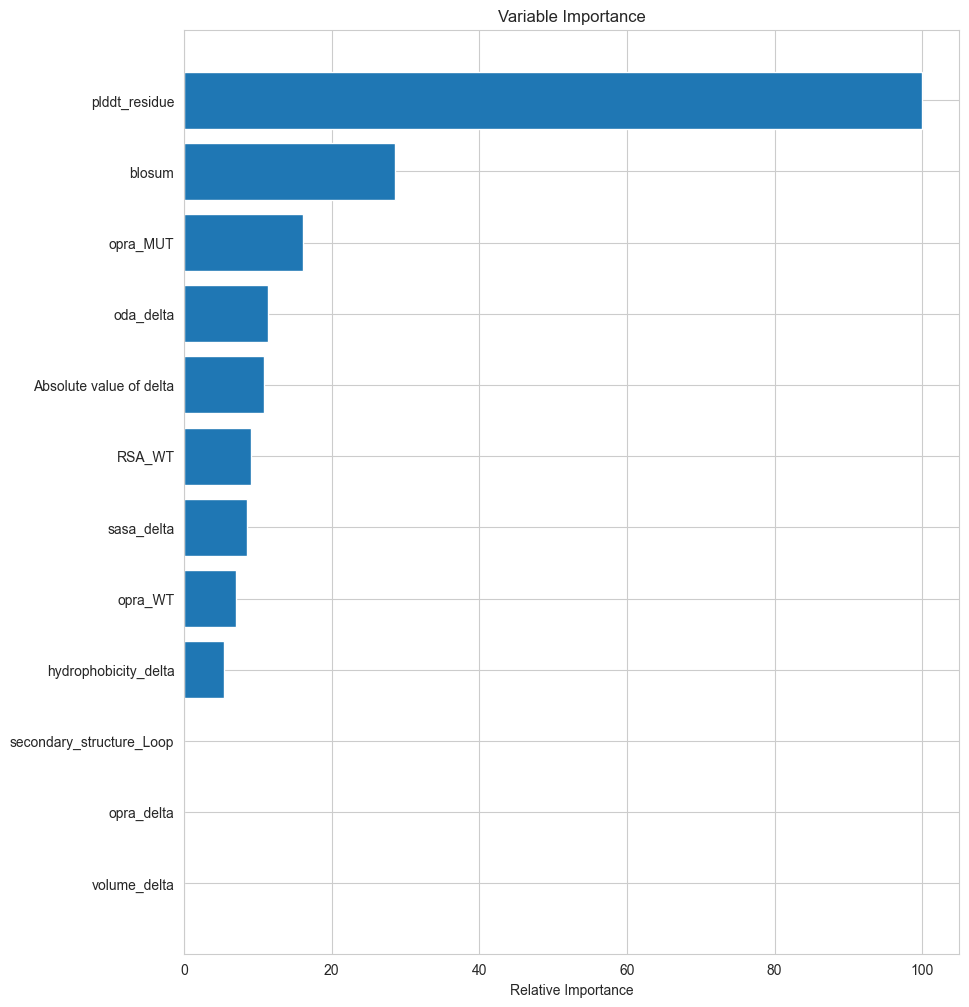

In [67]:
# Create feature importance plot
feature_importance = xgb_classifier.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()